In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import math
import keras
from keras.models import model_from_yaml
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
from sklearn.externals.joblib import dump, load
import tensorflow as tf
import os
from sklearn import preprocessing
from datetime import datetime
import time
import re


Using TensorFlow backend.
/Users/d070867/miniconda3/envs/pjawt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def get_top_autcorr(data_frame, max_lag = 500, highest_corr = 10):
    lag_corr = []
    for j in range(0,max_lag):
        corrs = []
        for i in range(0,data_frame.shape[0]):
            ts = pd.Series(data_frame.iloc[[i]].values[0])
            corrs.append(ts.autocorr(lag=j))
        lag_corr.append(np.mean(corrs))
    
    correlations = np.array(lag_corr)    
    highest_correlations_ind = np.flip(correlations.argsort()[-highest_corr:])
    return correlations[highest_correlations_ind], highest_correlations_ind


In [6]:
file_path = "Dataset/Train/Hourly-train.csv"
df = pd.read_csv(file_path)
del df['V1']

top_correlations, top_lags = get_top_autcorr(df)
print(top_correlations)
print(top_lags )

NameError: name 'get_top_autcorr' is not defined

In [2]:
file_path = "Dataset/Train/Hourly-train-2.csv"
df = pd.read_csv(file_path)
del df['V1']
#df = df.dropna()
vals = df.values
vals.reshape(-1,48).shape

(8280, 48)

In [3]:
def smape(yTrue, yPred):
    """
    Calculates sMAPE

    :param yTrue: actual values
    :param yPred: predicted values
    :return: sMAPE
    """
    #a = np.reshape(a, (-1,))
    #b = np.reshape(b, (-1,))
    return tf.reduce_mean(2.0 * tf.abs(yTrue - yPred) / (tf.abs(yTrue) + tf.abs(yPred)))

In [212]:
lambda_ = 24 # lambda in loss fn
alpha_ = 0.05  # capturing (1-alpha)% of samples
soften_ = 150.
n_ = 120 # batch size
r_ = 10^5
decay_lambda = 1/48
look_back = 652 # 700 time steps of which 48 are the forecasted values and 652 values the historical data


def weighted_MASE(y_true, y_pred, horizon):
    
    n = tf.shape(y_true)[0]
    e = tf.abs(tf.subtract(y_true, y_pred))
    max_e = tf.reduce_max(e)
    s_diff = tf.reduce_sum(tf.abs(tf.subtract(y_true[1:],y_true[:-1])), 0)
    d = 1/tf.multiply(tf.cast(n-1, tf.float32),s_diff)
    
    q = e/tf.expand_dims(d, 0)
    
    w = tf.tile(tf.range(horizon), [tf.cast(n/horizon, tf.int32)])
    w_q = q * tf.exp(-decay_lambda * tf.cast(w, tf.float32))
    
    MASE = tf.reduce_mean(w_q, 0)
    
    return MASE

def wMASE_loss(y_true, y_pred):
    
    horizon = tf.shape(y_true)[1]
    y_t = tf.reshape(y_true, [-1])
    y_f = tf.reshape(y_pred[:,1::3], [-1])
    
    n = tf.shape(y_t)[0]
    e = tf.abs(tf.subtract(y_t, y_f))
    max_e = tf.reduce_max(e)
    s_diff = tf.reduce_sum(tf.abs(tf.subtract(y_t[1:],y_t[:-1])), 0)
    d = 1/tf.multiply(tf.cast(n-1, tf.float32),s_diff)
    
    q = e/tf.expand_dims(d, 0)
    
    w = tf.tile(tf.range(horizon), [tf.cast(n/horizon, tf.int32)])
    w_q = q * tf.exp(-decay_lambda * tf.cast(w, tf.float32))
    
    MASE = tf.reduce_mean(w_q, 0)
    
    return MASE

def MASE_loss(y_true, y_pred):
    horizon = tf.shape(y_true)[1]
    y_t = tf.reshape(y_true, [-1])
    y_f = tf.reshape(y_pred[:,1::3], [-1])
    
    n = tf.shape(y_t)[0]
    e = tf.abs(tf.subtract(y_t, y_f))
    max_e = tf.reduce_max(e)
    s_diff = tf.reduce_sum(tf.abs(tf.subtract(y_t[1:],y_t[:-1])), 0)
    d = 1/tf.multiply(tf.cast(n-1, tf.float32),s_diff)
    
    q = e/tf.expand_dims(d, 0)
    
    return tf.reduce_mean(q, 0)

def PICP_loss(y_true, y_pred):
    y_t = tf.reshape(y_true, [-1])
    y_u = tf.reshape(y_pred[:,::3], [-1])
    y_l = tf.reshape(y_pred[:,2::3], [-1])
    
    K_HU = tf.maximum(0.,tf.sign(y_u - y_t))
    K_HL = tf.maximum(0.,tf.sign(y_t - y_l))
    K_H = tf.multiply(K_HU, K_HL)

    return tf.reduce_mean(K_H)

def MPIW_c_loss(y_true, y_pred):
    y_t = tf.reshape(y_true, [-1])
    y_u = tf.reshape(y_pred[:,::3], [-1])
    y_l = tf.reshape(y_pred[:,2::3], [-1])
    
    K_HU = tf.maximum(0.,tf.sign(y_u - y_t))
    K_HL = tf.maximum(0.,tf.sign(y_t - y_l))
    K_H = tf.multiply(K_HU, K_HL)
    
    return tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/(tf.reduce_sum(K_H) + 1)

def MPIW_b_loss(y_true, y_pred):

    y_t = tf.reshape(y_true, [-1])
    y_u = tf.reshape(y_pred[:,::3], [-1])
    y_l = tf.reshape(y_pred[:,2::3], [-1])
    
    K_HU = tf.maximum(0.,tf.sign(y_u - y_t))
    K_HL = tf.maximum(0.,tf.sign(y_t - y_l))
    K_H = tf.multiply(K_HU, K_HL)
    
    C = tf.reduce_sum(K_H)
    
    return tf.reduce_mean(tf.multiply((y_u - y_l),K_H)) * C/tf.cast(tf.shape(K_H), tf.float32) + tf.reduce_mean(tf.abs(K_H-1))**(C)

def qd_objective_lstm_b(y_true, y_pred):
    '''Loss_QD-soft, from algorithm 1'''
    h = tf.shape(y_true)[1]
    y_t = tf.reshape(y_true, [-1])
    y_u = tf.reshape(y_pred[:,::3], [-1])
    y_f = tf.reshape(y_pred[:,1::3], [-1])
    y_l = tf.reshape(y_pred[:,2::3], [-1])
    
    wMASE = weighted_MASE(y_t, y_f, h)
    
    K_HU = tf.maximum(0.,tf.sign(y_u - y_t))
    K_HL = tf.maximum(0.,tf.sign(y_t - y_l))
    K_H = tf.multiply(K_HU, K_HL)
    
    K_SU = tf.sigmoid(soften_ * (y_u - y_t))
    K_SL = tf.sigmoid(soften_ * (y_t - y_l))
    K_S = tf.multiply(K_SU, K_SL)
    
    C = tf.reduce_sum(K_H)
    MPIW_b = tf.reduce_mean(tf.multiply((y_u - y_l),K_H)) * C/tf.cast(tf.shape(K_H), tf.float32) + tf.reduce_mean(tf.abs(K_H-1))**(C)
    PICP_H = tf.reduce_mean(K_H)
    PICP_S = tf.reduce_mean(K_S)
    
    Loss_S = MPIW_b + lambda_ * (n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S) + wMASE)
    return Loss_S

def qd_objective_lstm_c(y_true, y_pred):
    '''Loss_QD-soft, from algorithm 1'''
    h = tf.shape(y_true)[1]
    y_t = tf.reshape(y_true, [-1])
    y_u = tf.reshape(y_pred[:,::3], [-1])
    y_f = tf.reshape(y_pred[:,1::3], [-1])
    y_l = tf.reshape(y_pred[:,2::3], [-1])
    
    wMASE = weighted_MASE(y_t, y_f, h)
    
    K_HU = tf.maximum(0.,tf.sign(y_u - y_t))
    K_HL = tf.maximum(0.,tf.sign(y_t - y_l))
    K_H = tf.multiply(K_HU, K_HL)
    
    K_SU = tf.sigmoid(soften_ * (y_u - y_t))
    K_SL = tf.sigmoid(soften_ * (y_t - y_l))
    K_S = tf.multiply(K_SU, K_SL)
    
    MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/(tf.reduce_sum(K_H) + 1)
    PICP_H = tf.reduce_mean(K_H)
    PICP_S = tf.reduce_mean(K_S)
    
    Loss_S = MPIW_c + lambda_ * (n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S) + wMASE)
    return Loss_S

In [213]:
from tensorflow.python.keras.utils import Sequence
import numpy as np   

class Mygenerator(Sequence):

    def __init__(self, raw_ts, in_ts_len, out_ts_len, batch_size):
        self.x, self.y = self.__create_training_data(raw_ts, in_ts_len, out_ts_len)
        self.batch_size = batch_size
    
    def __create_training_data(self, raw_ts, in_ts_len, out_ts_len):
        
        data_x =  np.empty(shape=[0, in_ts_len], dtype = np.float64)
        data_y =  np.empty(shape=[0, out_ts_len], dtype = np.float64)
        raw_ts = preprocessing.minmax_scale(raw_ts)

        i = 0
        
        while True:
            #print(data_x.shape)
            start_x_indx = i*in_ts_len
            end_x_indx = (i+1)*in_ts_len
            end_y_indx = end_x_indx + out_ts_len
            
            if end_y_indx > raw_ts.shape[1]:  break
                
            data_x = np.vstack((data_x, raw_ts[:, start_x_indx : end_x_indx ]))
            data_y = np.vstack((data_y, raw_ts[:, end_x_indx : end_y_indx]))
            
            i+=1
        

        data_x = data_x[~np.isnan(data_y).any(axis=1)]
        data_y = data_y[~np.isnan(data_y).any(axis=1)]
        
        x = np.arange(0,data_x.shape[1])
        
        #data_x = preprocessing.minmax_scale(data_x, axis=0)
        #data_y = preprocessing.minmax_scale(data_y, axis=0)
        
        return data_x, data_y
            

    def __len__(self):
        return int(np.floor(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size, :]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size, :]
        

        return np.array(batch_x)[:,:,np.newaxis], np.array(batch_y)[:,:]

    def get_data(self):
        return self.x, self.y

In [252]:
EPOCHS = 10
BS = 10
in_ts_len = 652
out_ts_len = 48

gen = Mygenerator(df.values, in_ts_len, out_ts_len, BS)

print(gen.__len__())
model = Sequential()


model.add(LSTM(144, batch_input_shape=(BS, in_ts_len, 1),  activation='tanh',
              kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))

model.add(Dense(144, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3)))

opt = keras.optimizers.RMSprop(lr=0.01)#, clipvalue=0.05)

#model.compile(loss='mean_squared_error', optimizer=opt)
model.compile(loss=qd_objective_lstm_b, optimizer=opt)
#model.compile(loss=smape, optimizer=opt)

41


In [253]:
hist = model.fit_generator(gen, steps_per_epoch= gen.__len__(), epochs=EPOCHS)

Epoch 1/10
41/41 [==============================] - 12s 299ms/step - loss: 41709.7410
Epoch 2/10
41/41 [==============================] - 12s 283ms/step - loss: 38249.5774
Epoch 3/10
41/41 [==============================] - 11s 275ms/step - loss: 34599.7167
Epoch 4/10
41/41 [==============================] - 12s 287ms/step - loss: 28911.0874
Epoch 5/10
41/41 [==============================] - 11s 280ms/step - loss: 28219.6058
Epoch 6/10
41/41 [==============================] - 11s 279ms/step - loss: 28989.2691
Epoch 7/10
41/41 [==============================] - 11s 280ms/step - loss: 26275.0164
Epoch 8/10
41/41 [==============================] - 12s 285ms/step - loss: 24276.4097
Epoch 9/10
41/41 [==============================] - 12s 281ms/step - loss: 22419.9639
Epoch 10/10
41/41 [==============================] - 12s 284ms/step - loss: 21925.6792


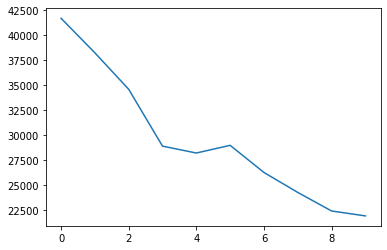

In [254]:
#print(lhist.history['loss'])

x = np.arange(0,10) 
y = np.array(hist.history['loss'])
#y = preprocessing.minmax_scale(y, axis=0)
plt.plot(x,y[:10])

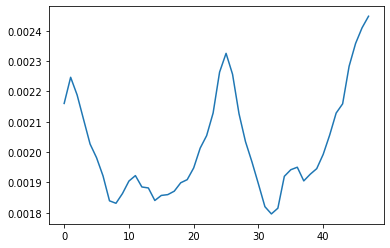

In [255]:
x, y = gen.get_data()

time = np.arange(0, y.shape[1])

plt.plot(time, y[2,:])

(414, 652)
(10, 144)
(10, 48)


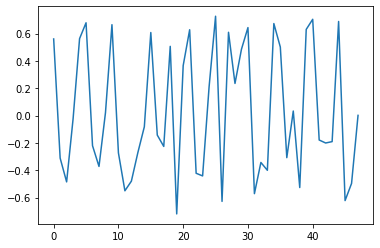

In [260]:
x, y = gen.get_data()
print(x.shape)
x = x[:BS,:].reshape(BS, -1, 1)

prediction = model.predict(np.array(x), batch_size=BS)
print(prediction.shape)
#prediction = prediction.reshape(BS,-1,3)
prediction = prediction[:,1::3]
print(prediction.shape)

time = np.arange(0, prediction.shape[1])

plt.plot(time, prediction[2,:])


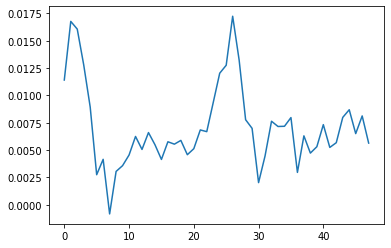

In [180]:
plt.plot(x,prediction[3,:])

In [164]:
data_all = np.array(np.random.random_integers(0, 10, (200, 48)), dtype=np.float32)
data_all = data_all.reshape(200,48,1)
y = model.predict(data_all)


/Users/d070867/miniconda3/envs/pjawt/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
  """Entry point for launching an IPython kernel.


InvalidArgumentError:  Specified a list with shape [50,1] from a tensor with shape [32,1]
	 [[node lstm_36/TensorArrayUnstack/TensorListFromTensor (defined at /Users/d070867/miniconda3/envs/pjawt/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_282774]

Function call stack:
keras_scratch_graph


In [151]:
model.get_weights()

[array([[-1.65164247e-01,  1.67526290e-01, -1.08571269e-01,
         -6.89750072e-03, -2.53314346e-01,  1.42583877e-01,
         -1.92291424e-01, -2.07468763e-01, -3.90120149e-01,
          4.21790153e-01,  4.47628014e-02, -2.14987621e-02,
         -2.26470575e-01,  4.43264935e-03,  3.69962960e-01,
          1.80921406e-01, -1.94439486e-01, -1.84130669e-01,
          1.45917416e-01,  1.49350747e-01, -2.05053613e-01,
          3.20903778e-01, -1.45119786e-01,  1.15011685e-01,
          2.60598302e-01,  2.95873940e-01,  5.40517643e-02,
         -3.98783386e-01, -1.14910170e-01,  7.45375156e-02,
         -2.86367357e-01, -8.89262706e-02, -1.01978324e-01,
          2.07250372e-01,  5.91902323e-02,  4.67777140e-02,
         -2.56584674e-01, -2.20430177e-02,  6.67471811e-02,
         -9.98160392e-02, -3.25579904e-02, -3.27776819e-01,
         -1.05423965e-01,  3.04784596e-01, -5.35113178e-02,
          8.54018852e-02,  3.28941643e-01, -6.02837026e-05,
         -1.16159111e-01,  1.63960546e-0